#### Python notebook using data from https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/data

## Description
Since the first automobile, the Benz Patent Motor Car in 1886, Mercedes-Benz has stood for important automotive innovations. These include, for example, the passenger safety cell with crumple zone, the airbag and intelligent assistance systems. Mercedes-Benz applies for nearly 2000 patents per year, making the brand the European leader among premium car makers. Daimler’s Mercedes-Benz cars are leaders in the premium car industry. With a huge selection of features and options, customers can choose the customized Mercedes-Benz of their dreams.

To ensure the safety and reliability of each and every unique car configuration before they hit the road, Daimler’s engineers have developed a robust testing system. But, optimizing the speed of their testing system for so many possible feature combinations is complex and time-consuming without a powerful algorithmic approach. As one of the world’s biggest manufacturers of premium cars, safety and efficiency are paramount on Daimler’s production lines.
<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/6565/media/daimler-mercedes%20V02.jpg" />
In this competition, Daimler is challenging Kagglers to tackle the curse of dimensionality and reduce the time that cars spend on the test bench. Competitors will work with a dataset representing different permutations of Mercedes-Benz car features to predict the time it takes to pass testing. Winning algorithms will contribute to speedier testing, resulting in lower carbon dioxide emissions without reducing Daimler’s standards.

## Data
Dataset contains an anonymized set of variables, each representing a custom feature in a Mercedes car. For example, a variable could be 4WD, added air suspension, or a head-up display.
The ground truth is labeled `y` and represents the time (`in seconds`) that the car took to pass testing for each variable.

`File descriptions`
Variables with letters are categorical. Variables with 0/1 are binary values.

* `train.csv` - the training set
* `test.csv` - the test set, you must predict the `y` variable for the 'ID's in this file
* `sample_submission.csv` - a sample submission file in the correct format

## Evaluation
Submissions are evaluated on the R^2 value.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### 1. General information about data

In [2]:
train = pd.read_csv("data/train.csv.zip")
test = pd.read_csv("data/test.csv.zip")
sub = pd.read_csv("data/sample_submission.csv.zip")

print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (4209, 378)
Test shape :  (4209, 377)


In [3]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


### 2. Exploratory Data Analysis

#### 2.1 Target analysis

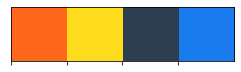

In [4]:
colors = ['#ff671d', '#ffdb1d', '#2c3e50', '#197bee']
sns.palplot(sns.color_palette(colors))

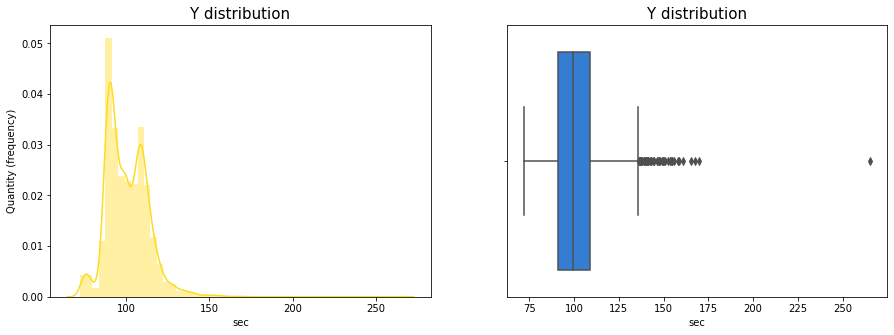

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(train.y.values, bins=50, color=colors[1])
plt.title('Y distribution', fontsize=15)
plt.xlabel('sec')
plt.ylabel('Quantity (frequency)');

plt.subplot(122)
sns.boxplot(train.y.values, color=colors[3])
plt.title('Y distribution', fontsize=15)
plt.xlabel('sec');

In [6]:
train.y.describe()

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64

The target `y` has a standard distribution of about 72 to 140 seconds. The first and third quartiles lie in the range from about 91 to 109 seconds, the median is 100 seconds, we also note that there are outliers starting from 140 seconds that we can remove from the training sample, since these values will add noise to our algorithm.

#### 2.2 Data types

In [7]:
train.dtypes.value_counts()

int64      369
object       8
float64      1
dtype: int64

In [8]:
train.dtypes[train.dtypes=='float']

y    float64
dtype: object

In [9]:
train.dtypes[train.dtypes=='object']

X0    object
X1    object
X2    object
X3    object
X4    object
X5    object
X6    object
X8    object
dtype: object

In [10]:
obj = train.dtypes[train.dtypes=='object'].index
for i in obj:
    print(i, train[i].unique())

X0 ['k' 'az' 't' 'al' 'o' 'w' 'j' 'h' 's' 'n' 'ay' 'f' 'x' 'y' 'aj' 'ak' 'am'
 'z' 'q' 'at' 'ap' 'v' 'af' 'a' 'e' 'ai' 'd' 'aq' 'c' 'aa' 'ba' 'as' 'i'
 'r' 'b' 'ax' 'bc' 'u' 'ad' 'au' 'm' 'l' 'aw' 'ao' 'ac' 'g' 'ab']
X1 ['v' 't' 'w' 'b' 'r' 'l' 's' 'aa' 'c' 'a' 'e' 'h' 'z' 'j' 'o' 'u' 'p' 'n'
 'i' 'y' 'd' 'f' 'm' 'k' 'g' 'q' 'ab']
X2 ['at' 'av' 'n' 'e' 'as' 'aq' 'r' 'ai' 'ak' 'm' 'a' 'k' 'ae' 's' 'f' 'd'
 'ag' 'ay' 'ac' 'ap' 'g' 'i' 'aw' 'y' 'b' 'ao' 'al' 'h' 'x' 'au' 't' 'an'
 'z' 'ah' 'p' 'am' 'j' 'q' 'af' 'l' 'aa' 'c' 'o' 'ar']
X3 ['a' 'e' 'c' 'f' 'd' 'b' 'g']
X4 ['d' 'b' 'c' 'a']
X5 ['u' 'y' 'x' 'h' 'g' 'f' 'j' 'i' 'd' 'c' 'af' 'ag' 'ab' 'ac' 'ad' 'ae'
 'ah' 'l' 'k' 'n' 'm' 'p' 'q' 's' 'r' 'v' 'w' 'o' 'aa']
X6 ['j' 'l' 'd' 'h' 'i' 'a' 'g' 'c' 'k' 'e' 'f' 'b']
X8 ['o' 'x' 'e' 'n' 's' 'a' 'h' 'p' 'm' 'k' 'd' 'i' 'v' 'j' 'b' 'q' 'w' 'g'
 'y' 'l' 'f' 'u' 'r' 't' 'c']


#### 2.3 Missing data

In [11]:
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

#### 2.4 Categorical variables

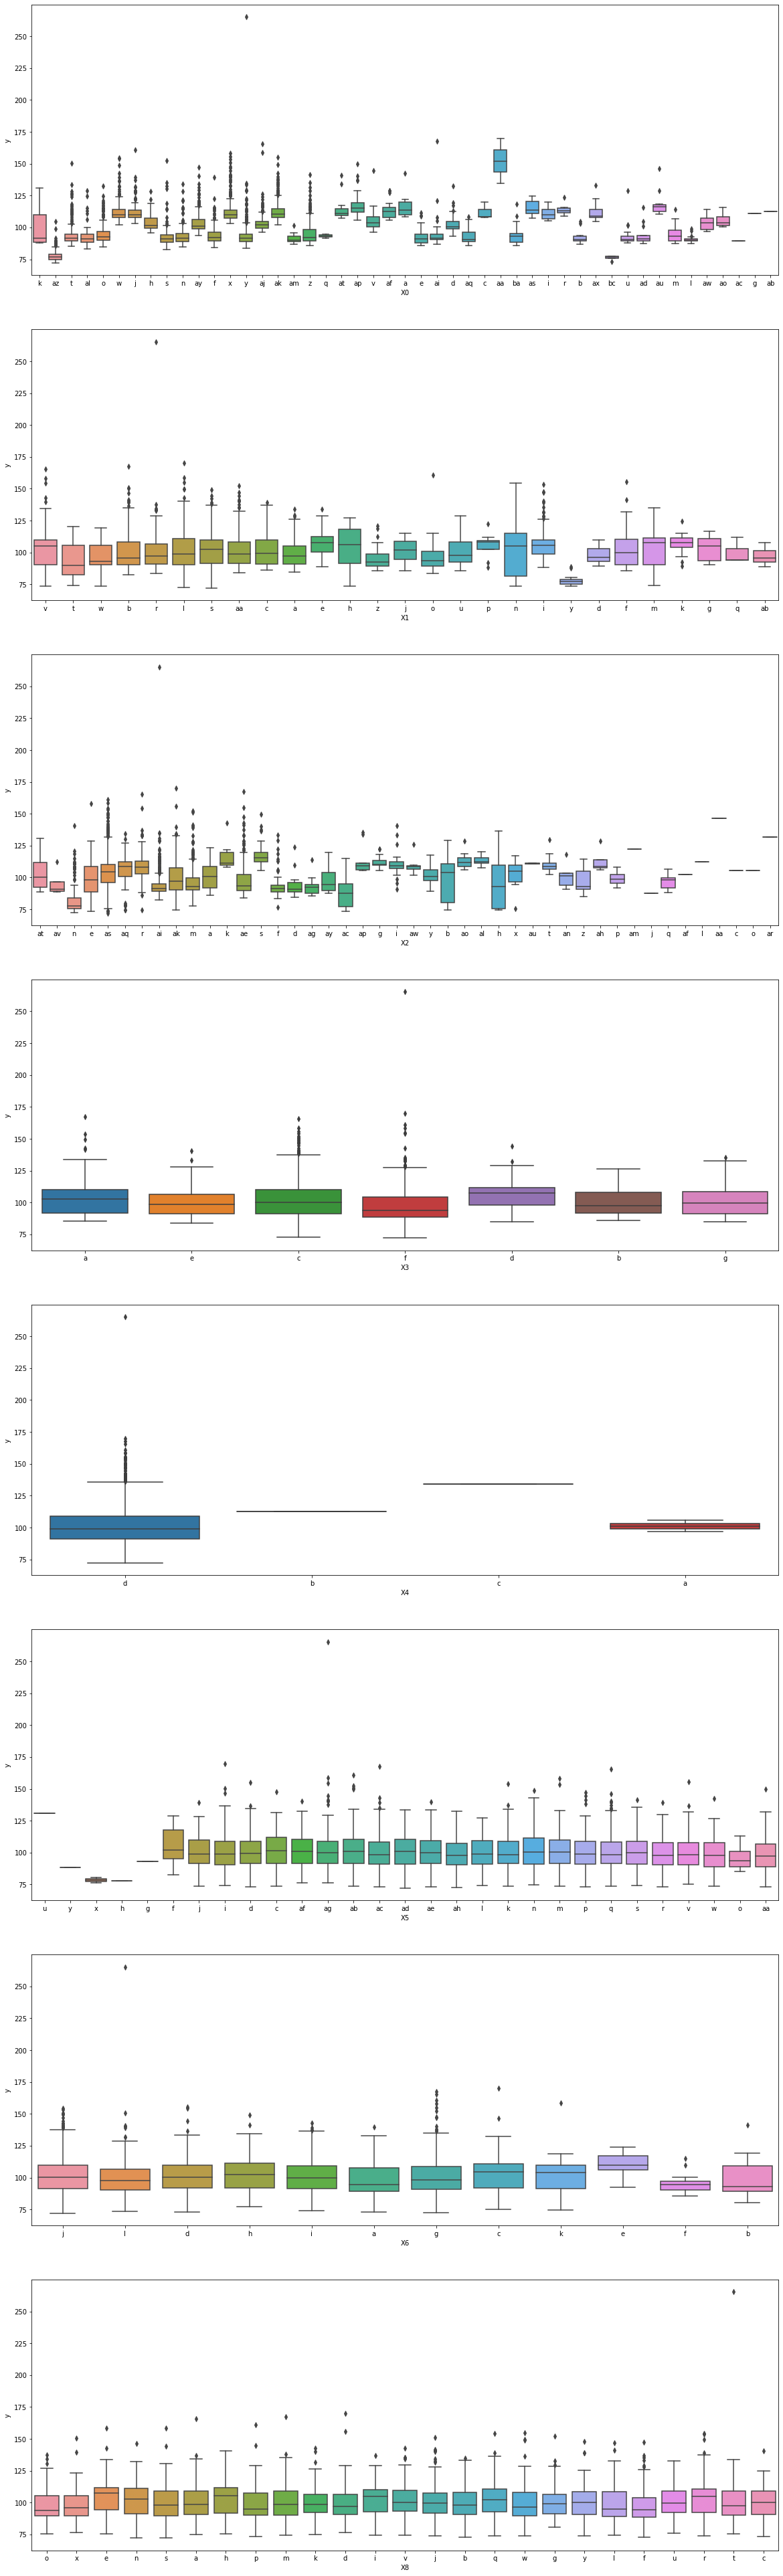

In [12]:
fig, ax = plt.subplots(len(obj), figsize=(20,70))
for i, col in enumerate(obj):
    sns.boxplot(x=col, y='y', data=train, ax=ax[i])

Subconclusion:

> Since there is a need to reduce the testing time, then the best values in the variables at which this time is minimal are az and bc (X0), y (X1), n (X2), x and h (X5) (hypothesis: may affect on y?)

> The variables X3, X5, X6, X8 have similar distributions of values, where there are no special differences within the feature between the values in the context of means and quartiles

> X0 and X2 have the greatest variety within variables, which can potentially indicate a greater usefulness of these features

#### 2.5 Numeric variables

In [13]:
num = train.dtypes[train.dtypes=='int'].index[1:]

There're a set of numeric variables, where the value is set to 1 or 0, so there is no need to carry out volumetric analysis. In this case, we should be interested in whether the value of indicators changes within the variables, for this we examine the variance of these variables, use the var () function, and select only those where the variance is zero (that is, always 0, or 1 on the entire dataset in variable cut).

In [14]:
nan_num = []
for i in num:
    if (train[i].var()==0):
        print(i, train[i].var())
        nan_num.append(i)

The analysis did not reveal variables equal to zero.
If such variables were identified, then they should be excluded from the training dataset, since they would negatively affect the accuracy of the target variable. Thus, by eliminating these variables, we improve the performance of the algorithm.

In [15]:
# uncomment the code if variables are found equal to zero
# train = train.drop(columns=nan_num, axis=1)

#### 2.6 Correlation analysis

In order for us to be able to do a correlation analysis for categorical variables, then before that we need to transform these variables using LabelEncoder (), when converting values to a binary form, we will not be able to track the relationship of a particular variable + we must take into account the test set, since its values will participate when finding a target.

In [16]:
for i in obj:
    le = LabelEncoder()
    le.fit(list(train[i].values) + list(train[i].values))
    train[i] = le.transform(list(train[i].values))

In [17]:
train[obj].head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,32,23,17,0,3,24,9,14
1,32,21,19,4,3,28,11,14
2,20,24,34,2,3,27,9,23
3,20,21,34,5,3,27,11,4
4,20,23,34,5,3,12,3,13


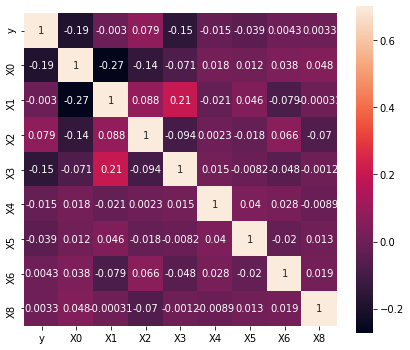

In [18]:
corr = train[train.columns[1:10]].corr()

fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(corr, vmax=0.7, square=True, annot=True);

Among the categorical variables, no variables with direct dependence with the target `y` were found.

In [19]:
threshold = 1

corr_all = train.drop(columns=obj, axis=1).corr()
corr_all.loc[:,:] = np.tril(corr_all, k=-1) 

In [20]:
already_in = set()
result = []
for col in corr_all:
    perfect_corr = corr_all[col][corr_all[col] == threshold ].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result.append(perfect_corr)

In [21]:
result

[['X382', 'X17'],
 ['X232', 'X279', 'X29'],
 ['X35', 'X37', 'X31'],
 ['X39', 'X33'],
 ['X302', 'X44'],
 ['X113', 'X134', 'X147', 'X222', 'X48'],
 ['X102', 'X214', 'X239', 'X53'],
 ['X76', 'X54'],
 ['X324', 'X58'],
 ['X248', 'X253', 'X385', 'X60'],
 ['X172', 'X216', 'X62'],
 ['X213', 'X67'],
 ['X84', 'X244', 'X71'],
 ['X122', 'X243', 'X320', 'X88'],
 ['X245', 'X89'],
 ['X94', 'X242', 'X90'],
 ['X199', 'X112'],
 ['X119', 'X118'],
 ['X227', 'X125'],
 ['X146', 'X138'],
 ['X226', 'X326', 'X152'],
 ['X360', 'X155'],
 ['X262', 'X266', 'X184'],
 ['X247', 'X202'],
 ['X254', 'X230'],
 ['X364', 'X365', 'X240'],
 ['X296', 'X295'],
 ['X299', 'X298']]

When analyzing numerical variables, we found that some of them have a direct correlation with others, therefore, in order to avoid multicollinearity, we can remove variables with correlation 1 (leave one of the group), or use regularization so that the algorithm does it in automatic mode.

How else can we remove such variables without correlation? Everything is simple, we delete duplicates in the section of columns.

In [22]:
# A more optimal way to remove duplicate variables from a dataset
train.T.drop_duplicates().T

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384
0,0.0,130.81,32.0,23.0,17.0,0.0,3.0,24.0,9.0,14.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,6.0,88.53,32.0,21.0,19.0,4.0,3.0,28.0,11.0,14.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,76.26,20.0,24.0,34.0,2.0,3.0,27.0,9.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.0,80.62,20.0,21.0,34.0,5.0,3.0,27.0,11.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.0,78.02,20.0,23.0,34.0,5.0,3.0,12.0,3.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405.0,107.39,8.0,20.0,16.0,2.0,3.0,0.0,3.0,16.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4205,8406.0,108.77,31.0,16.0,40.0,3.0,3.0,0.0,7.0,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4206,8412.0,109.22,8.0,23.0,38.0,0.0,3.0,0.0,6.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4207,8415.0,87.48,9.0,19.0,25.0,5.0,3.0,0.0,11.0,20.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
